In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=b3bf60dd2c74ce49b6b88045985736db724b0b2a4edf97f39e09958f7ad6d564
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [ ]:
#importing packages
import pandas as pd
import numpy as np
import tensorflow as tf
import pywt
import keras
from keras_self_attention import SeqSelfAttention

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Lambda, Bidirectional, GRU, Conv1D, TimeDistributed
from tensorflow.keras.layers import RepeatVector, MaxPooling1D, Input, Attention, Concatenate, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
#setting figure size
rcParams['figure.figsize'] = 20,10

#for normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/My Drive/DATA/SPY_JULY15_JULY20.csv')
df_idx = pd.read_csv('/content/drive/My Drive/DATA/USD_IDX_JULY15_JULY20.csv')
df_idx = df_idx.fillna(method='bfill', axis=0)

#df['Date'] = df[['Date', 'Time']].apply(lambda x: '-'.join(x), axis=1)
#print the head


In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-27,206.940002,207.550003,206.259995,206.789993,187.214249,132361100
1,2015-07-28,207.789993,209.500000,206.800003,209.330002,189.513840,123544800
2,2015-07-29,209.479996,211.039993,209.309998,210.770004,190.817490,105791300
3,2015-07-30,210.160004,211.020004,209.419998,210.820007,190.862778,91304400
4,2015-07-31,211.419998,211.449997,210.160004,210.500000,190.573059,103266900
...,...,...,...,...,...,...,...
1254,2020-07-20,321.429993,325.130005,320.619995,324.320007,324.320007,56308800
1255,2020-07-21,326.450012,326.929993,323.940002,325.010010,325.010010,57499000
1256,2020-07-22,324.619995,327.200012,324.500000,326.859985,326.859985,57792900
1257,2020-07-23,326.470001,327.230011,321.480011,322.959991,322.959991,75738000


In [ ]:
df_idx

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-27,97.199997,97.290001,96.290001,96.500000,96.500000,0.0
1,2015-07-28,96.580002,96.970001,96.470001,96.769997,96.769997,0.0
2,2015-07-29,96.650002,97.250000,96.500000,96.980003,96.980003,0.0
3,2015-07-30,97.139999,97.769997,97.139999,97.559998,97.559998,0.0
4,2015-07-31,97.470001,97.599998,96.309998,97.370003,97.370003,0.0
...,...,...,...,...,...,...,...
1513,2020-07-19,96.010002,96.180000,95.730003,95.830002,95.830002,0.0
1514,2020-07-20,96.010002,96.180000,95.730003,95.830002,95.830002,0.0
1515,2020-07-21,95.750000,95.919998,95.050003,95.120003,95.120003,0.0
1516,2020-07-22,95.129997,95.410004,94.830002,94.970001,94.970001,0.0


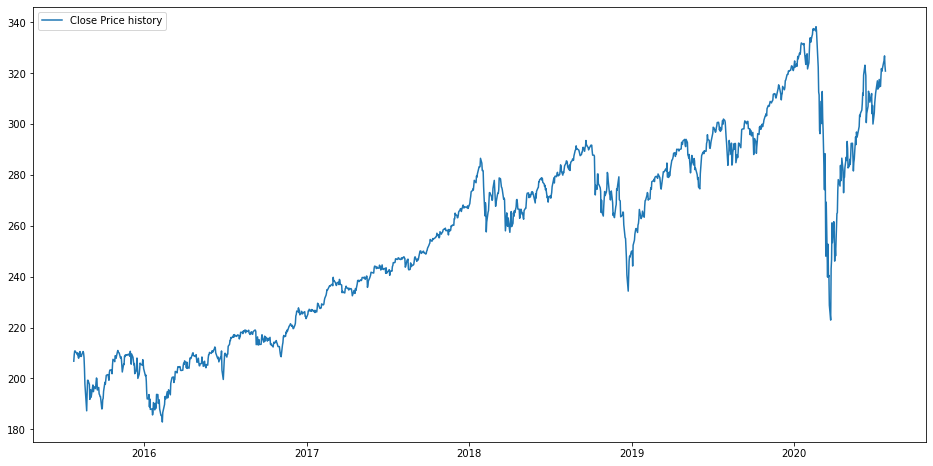

In [ ]:
#setting index as date
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']
#df = df[df['Date'] < '2020-01-01']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.legend()

In [ ]:
#US DOLLAR INDEX
df_idx['Date'] = pd.to_datetime(df_idx.Date)
df_idx.index = df_idx['Date']
df_idx = df_idx.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df_idx = df_idx.rename(columns={'Close': 'USD Index'})

# plt.plot(df_idx['USD Index'], label='Close US DOLLAR INDEX history')
# plt.legend()


In [ ]:
#merging dataframes
df = pd.merge(df, df_idx, how='left', left_index=True, right_index=True)
df = df.fillna(method='ffill', axis=0)
df = df.drop(['Date_y'], axis=1)
df = df.rename(columns={'Date_x':'Date'})
df

,Date,Open,High,Low,Close,Adj Close,Volume,USD Index
Date,,,,,,,,
2015-07-27,2015-07-27,206.940002,207.550003,206.259995,206.789993,187.214249,132361100,96.500000
2015-07-28,2015-07-28,207.789993,209.500000,206.800003,209.330002,189.513840,123544800,96.769997
2015-07-29,2015-07-29,209.479996,211.039993,209.309998,210.770004,190.817490,105791300,96.980003
2015-07-30,2015-07-30,210.160004,211.020004,209.419998,210.820007,190.862778,91304400,97.559998
2015-07-31,2015-07-31,211.419998,211.449997,210.160004,210.500000,190.573059,103266900,97.370003
...,...,...,...,...,...,...,...,...
2020-07-20,2020-07-20,321.429993,325.130005,320.619995,324.320007,324.320007,56308800,95.830002
2020-07-21,2020-07-21,326.450012,326.929993,323.940002,325.010010,325.010010,57499000,95.120003
2020-07-22,2020-07-22,324.619995,327.200012,324.500000,326.859985,326.859985,57792900,94.970001


In [ ]:
plt.plot(df['Close']/np.max(df['Close']), label='Close Price history')
plt.plot(df['Open']/np.max(df['Open']), label='Open Price history')
plt.plot(df['Volume']/np.max(df['Volume']), label='Sales Volume history')
plt.plot(df['USD Index']/np.max(df['USD Index']), label='USD Index history')
plt.legend()

In [ ]:
plt.plot(df['Close'][0:300], label='Close Price history')
plt.legend()

In [ ]:
#plot
plt.plot(df['Close'][-300:]/np.max(df['Close']), label='Close Price history')
plt.plot(df['Open'][-300:]/np.max(df['Open']), label='Open Price history')
plt.plot(df['Volume'][-300:]/np.max(df['Volume']), label='Sales Volume history')
plt.plot(df['USD Index'][-300:]/np.max(df['USD Index']), label='USD Index history')
plt.legend()

In [ ]:
#creating dataframe
T = 4 #training period
T_pred = 1 #prediction period

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close', 'Open', 'Volume'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    new_data['Open'][i] = data['Open'][i]
    new_data['Volume'][i] = data['Volume'][i]
    #new_data['USD Index'][i] = data['USD Index'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

new_data

,Close,Open,Volume
Date,,,
2015-07-27,206.79,206.94,132361100
2015-07-28,209.33,207.79,123544800
2015-07-29,210.77,209.48,105791300
2015-07-30,210.82,210.16,91304400
2015-07-31,210.5,211.42,103266900
...,...,...,...
2020-07-20,324.32,321.43,56308800
2020-07-21,325.01,326.45,57499000
2020-07-22,326.86,324.62,57792900


In [ ]:
#creating train and test sets
dataset = new_data.values
dataset_orig = dataset.copy()

#SNR of data before denoising
num = np.sum(dataset[:,0]**2)
den = np.sum((dataset[:,0] - np.mean(dataset[:,0]))**2)
SNR_before = 10*np.log10(num/den)
print('SNR of the signal before denoising: {}'.format(SNR_before))

#DWT on dataset
for i in range(dataset_orig.shape[1]):
  dataset[:,i] = denoise_wavelet(dataset[:,i].astype('float'), wavelet='coif3', mode='soft', method='VisuShrink', rescale_sigma=True)

#SNR of data after denoising
num = np.sum(dataset[:,0]**2)
den = np.sum((dataset[:,0] - np.mean(dataset[:,0]))**2)
SNR = 10*np.log10(num/den)
print('SNR of the signal after denoising: {}'.format(SNR))

split_constant = int(0.2*len(dataset)/T_pred)

train = dataset[:-T_pred*split_constant,:]
valid = dataset_orig[-T_pred*split_constant:,0].reshape(-1,1)

dataset.shape, train.shape, valid.shape, split_constant

SNR of the signal before denoising: 16.654729150718573
SNR of the signal after denoising: 16.668296867364596


((1259, 3), (1008, 3), (251, 1), 251)

In [ ]:
#converting dataset into x_train and y_train
k = train.shape[1] # number of features
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(T,len(train)-T_pred):
    x_train.append(scaled_data[i-T:i,:])
    y_train.append(scaled_data[i:i+T_pred,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],k))
y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))
print(x_train.shape, y_train.shape)


(1003, 4, 3) (1003, 1, 1)


Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
lstm_81 (LSTM)                  (None, 4, 200)       163200      input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm_82 (LSTM)                  [(None, 200), (None, 320800      lstm_81[0][0]                    
______________________________________________________________________________________

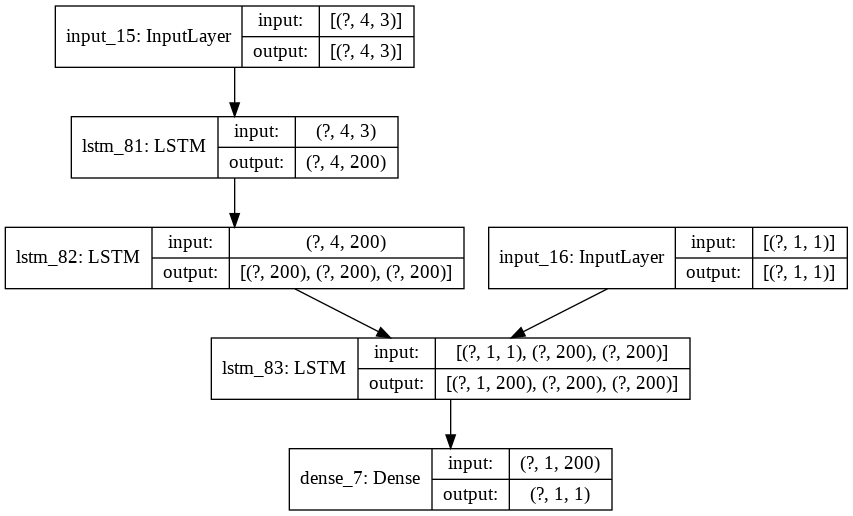

In [ ]:
#Encoder_Decoder style Inference model
model_name = 'enc_dec_test'
weight_save_path = '/content/drive/My Drive/LSTM/Results/'

#Setting up the data for Encoder_Decoder model
encoder_input_data = x_train
decoder_target_data = y_train
decoder_input_data = np.zeros((x_train.shape[0], 1, 1))
decoder_input_data[:, 0, 0] = encoder_input_data[:, T-1, 0]
latent_dim = 200

#Setting up the model encoder
encoder_inputs = Input(shape=(T, k))
# x = Conv1D(filters=64, kernel_size=3, activation='relu')(encoder_inputs)
# x = MaxPooling1D(pool_size=2)(x)
x = LSTM(latent_dim, activation='tanh', return_sequences=True)(encoder_inputs)
# x = Dropout(0.2)(x)
encoder_outputs, state_h, state_c = LSTM(latent_dim, activation='tanh', return_state=True)(x)
states = [state_h, state_c]

#Setting up the model decoder
decoder_inputs = Input(shape=(1, 1))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_dense = Dense(1)

all_outputs = []
inputs = decoder_inputs
for _ in range(T_pred):
    # Run the decoder on one timestep
    #outputs = LSTM(latent_dim, return_sequences=True)(inputs, initial_state=states)
    outputs, state_h, state_c = decoder_lstm(inputs,
                                             initial_state=states)
    #outputs, state_h, state_c = decoder_lstm(outputs)
    outputs = decoder_dense(outputs)
    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]

# Concatenate all predictions
if T_pred>1:
  decoder_outputs = Lambda(lambda x: concatenate(x, axis=1))(all_outputs)
else:
  decoder_outputs = all_outputs

# Define and compile model as previously
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mae'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)



In [ ]:
#Creating Attention layer
from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4, 3)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 200)            163200    
_________________________________________________________________
attention_3 (attention)      (None, 200)               204       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 200)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 200)            320800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 1)              201       
Total params: 484,405
Trainable params: 484,405
Non-trainable params: 0
________________________________________________

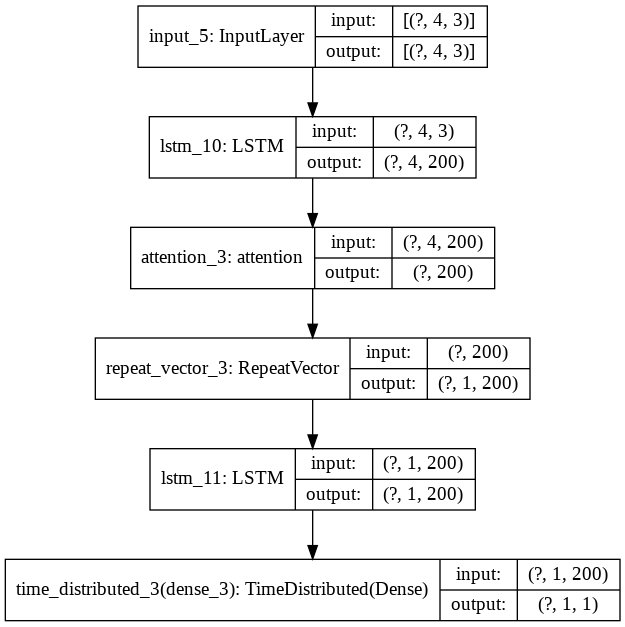

In [ ]:
#Attention model
model_name = 'att_test'
weight_save_path = '/content/drive/My Drive/LSTM/Results/'
inputs = Input((T,k))
#x = LSTM(200, return_sequences=True)(inputs)
att_in = LSTM(200, return_sequences=True)(inputs)
att_out = attention()(att_in)
x = RepeatVector(T_pred)(att_out)
x = LSTM(200, return_sequences=True)(x)
#x = LSTM(200, return_sequences=True)(x)
outputs = TimeDistributed(Dense(1))(x)
model = Model(inputs,outputs)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mae'])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
checkpoint = ModelCheckpoint(weight_save_path+model_name+'.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, )
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=200, mode='min',restore_best_weights=True)

In [ ]:
# import time
# start = time.time()
# history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           epochs=100, batch_size=32, callbacks=[lr_schedule])
# end = time.time()
# print('Run time: {}'.format((end-start)/60))

In [ ]:
import time
start = time.time()
history = model.fit(x_train, y_train,
          epochs=100, batch_size=32, callbacks=[lr_schedule])
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3799
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3799
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3799
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3799
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3799
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3798
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3798
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3798
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1863 - mae: 0.3798
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 0.1863 - mae: 0.3798
Epoch 11/100
32/32 [==============================] - 0s 5m

(1e-08, 0.01, 0.0, 1.0)

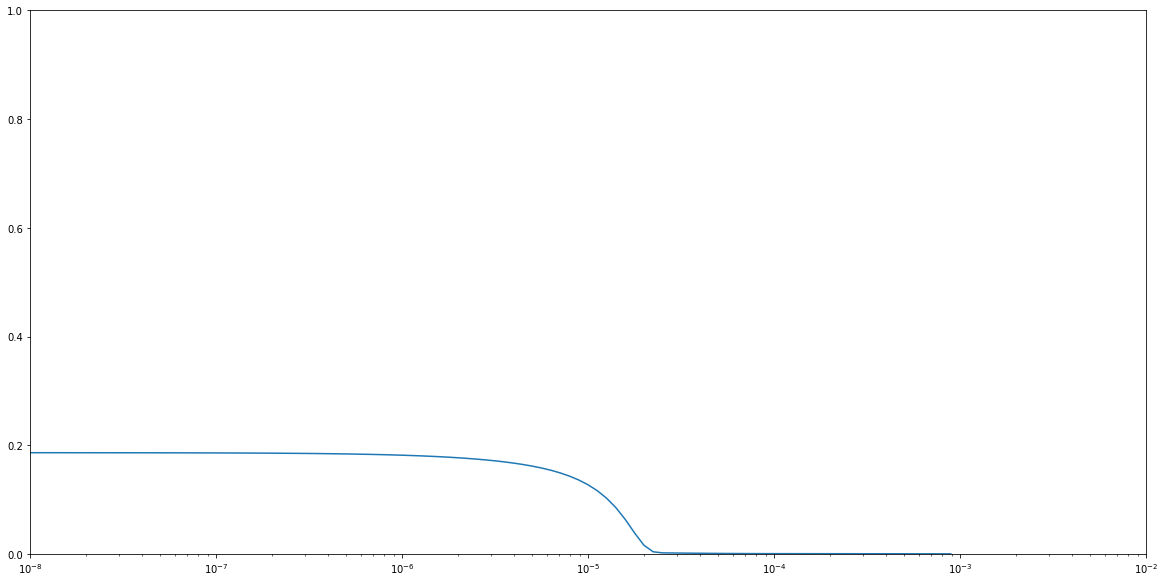

In [ ]:
#plotting loss per epoch against learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-2, 0, 1])
#use this to choose the optimum lr and run the NN for 500 epochs

In [ ]:
class stop_training(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('loss')<0.00001):
      print("Stopping training")
      self.model.stop_training = True

stop_training = stop_training()
model.compile(loss='mse', optimizer=Adam(lr=1e-4), metrics=['mae'])

import time
start = time.time()
# history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=32,
#           epochs=1000,
#           callbacks=[checkpoint, early_stop, stop_training],
#           validation_split=0.1)
history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=1000,
          callbacks=[checkpoint, early_stop, stop_training],
          validation_split=0.1)
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/1000
29/29 [==============================] - 1s 26ms/step - loss: 3.5130e-04 - mae: 0.0134 - val_loss: 4.4153e-04 - val_mae: 0.0177
Epoch 2/1000
29/29 [==============================] - 0s 5ms/step - loss: 3.2165e-04 - mae: 0.0128 - val_loss: 4.5538e-04 - val_mae: 0.0180
Epoch 3/1000
29/29 [==============================] - 0s 6ms/step - loss: 3.1764e-04 - mae: 0.0127 - val_loss: 2.2966e-04 - val_mae: 0.0115
Epoch 4/1000
29/29 [==============================] - 0s 5ms/step - loss: 3.2279e-04 - mae: 0.0130 - val_loss: 2.5028e-04 - val_mae: 0.0122
Epoch 5/1000
29/29 [==============================] - 0s 5ms/step - loss: 3.1428e-04 - mae: 0.0127 - val_loss: 3.4138e-04 - val_mae: 0.0151
Epoch 6/1000
29/29 [==============================] - 0s 5ms/step - loss: 3.1503e-04 - mae: 0.0126 - val_loss: 2.6943e-04 - val_mae: 0.0128
Epoch 7/1000
29/29 [==============================] - 0s 5ms/step - loss: 3.3219e-04 - mae: 0.0131 - val_loss: 2.3098e-04 - val_mae: 0.0117
Epoch 8/1000
29/29 

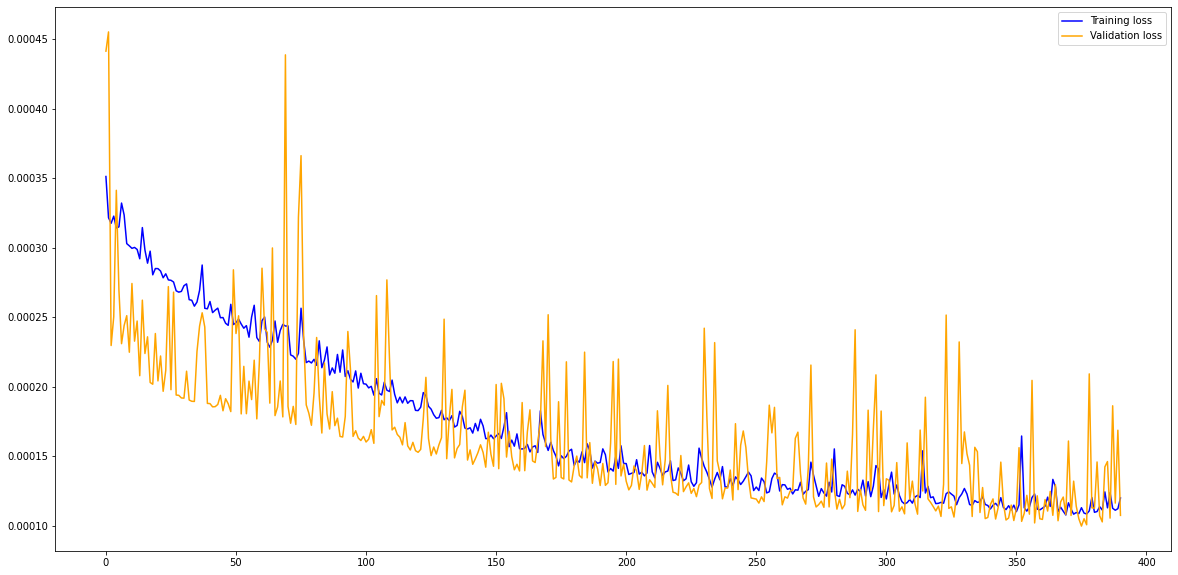

In [ ]:
#Plotting the loss
plt.plot(history.history['loss'], color='blue', label='Training loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation loss')
plt.legend()

In [ ]:
model.load_weights(weight_save_path+model_name+'.h5')


In [ ]:
# #Predictions on test set
# closing_price = np.zeros((len(valid)))
# x_test = dataset[-(len(valid)+T):,:]

# for i in range(0,len(valid),T_pred):
#   encoder_input_test_data = scaler.transform(x_test[i:i+T,:])
#   encoder_input_test_data = encoder_input_test_data.reshape(1,-1,k)
#   decoder_input_test_data = np.zeros((1, 1, 1))
#   decoder_input_test_data[0, 0, 0] = encoder_input_test_data[0, T-1, 0]
#   pred = model.predict([encoder_input_test_data, decoder_input_test_data])
#   closing_price[i:i+T_pred] = np.squeeze(pred)

# closing_price = closing_price.reshape(-1,1)
# closing_price = np.concatenate((closing_price, scaled_data[-(len(valid)):,1:]), axis=1)
# closing_price = scaler.inverse_transform(closing_price)
# closing_price = closing_price[:,0].reshape(-1,1)

# closing_price.shape

(251, 1)

In [ ]:
#Predictions on test set
closing_price = np.zeros((len(valid)))
X_test = dataset[-(len(valid)+T):,:]

for i in range(0,len(valid),T_pred):
  X_test_scaled = scaler.transform(X_test[i:i+T,:])
  X_test_scaled = X_test_scaled.reshape(1,-1,k)
  pred = model.predict(X_test_scaled)
  closing_price[i:i+T_pred] = np.squeeze(pred)

closing_price = closing_price.reshape(-1,1)
closing_price = np.concatenate((closing_price, scaled_data[-(len(valid)):,1:]), axis=1)
closing_price = scaler.inverse_transform(closing_price)
closing_price = closing_price[:,0].reshape(-1,1)

closing_price.shape

(251, 1)

In [ ]:
print(closing_price.shape)
print(x_test.shape)
print(valid.shape)

(251, 1)
(255, 3)
(251, 1)


In [ ]:
#rms error
rms = np.sqrt(np.mean(np.power((valid- closing_price),2)))
std = np.std(valid)
print('RMS error of the predictions on validation data: {:.2f}'.format(rms))
print('Standard deviation of the validation data: {:.2f}'.format(std))


RMS error of the predictions on validation data: 5.85
Standard deviation of the validation data: 21.43


In [ ]:
#Mean Absolute Percentage Error(MAPE)
MAPE = np.sum(np.abs((valid - closing_price)/valid)) / len(valid)
print('MAPE on validation data: {:.3f}'.format(MAPE),'\n')

#Correlation Coefficient R
mean_actual = np.mean(valid)
mean_predicted = np.mean(closing_price)
num = np.sum((valid - mean_actual)*(closing_price - mean_predicted)) 
den = np.sqrt(np.sum(((valid - mean_actual)**2))*np.sum(((closing_price - mean_predicted)**2)))
R = num/den
print('R of validation data: {:.2f}'.format(R), '\n')

#Theil's Inequality Coefficient Theil_U
num = np.sqrt((1/len(valid))*np.sum((valid - closing_price)**2))
den = np.sqrt((1/len(valid))*np.sum(valid**2)) + np.sqrt((1/len(valid))*np.sum(closing_price**2))
Theil_U = num/den
print('Theil U of validation data: {:.3f}'.format(Theil_U))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


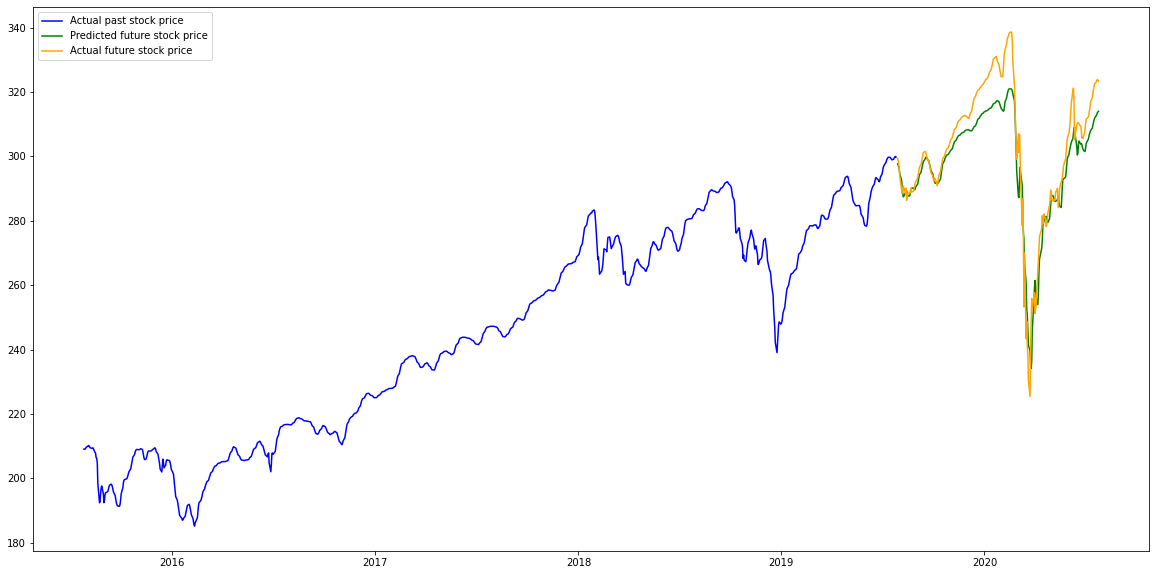

In [ ]:
#for plotting
train = new_data[:len(train)]
#train_pred = new_data[T:450]
valid = new_data[len(train):]
#train_pred['Predictions'] = closing_price_train
valid['Predictions'] = closing_price.reshape(-1,1)
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

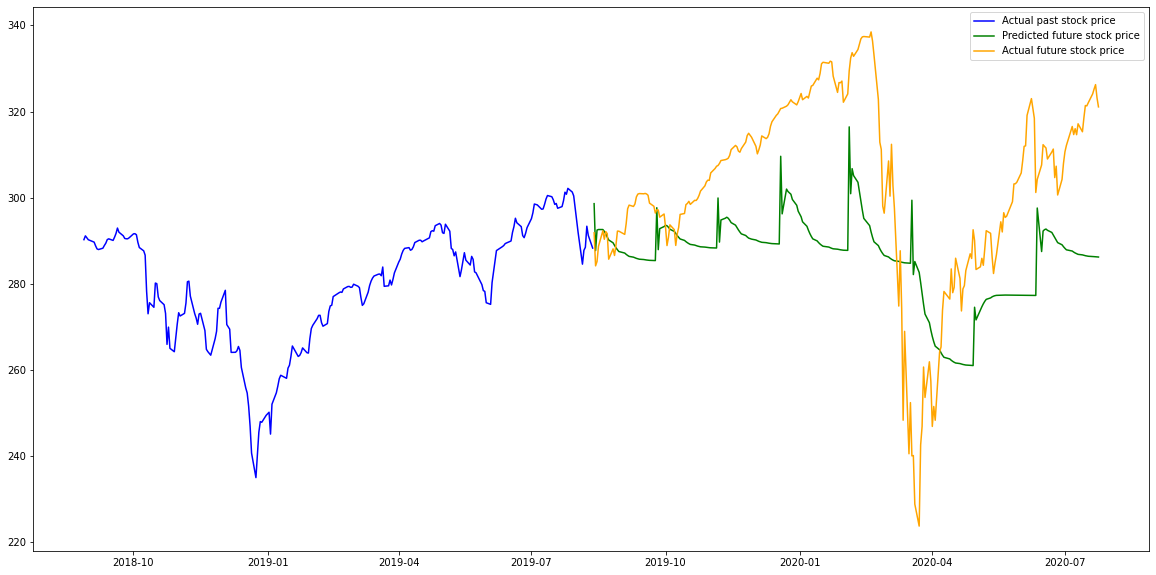

In [ ]:
plt.plot(train['Close'][len(train)-len(valid):], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

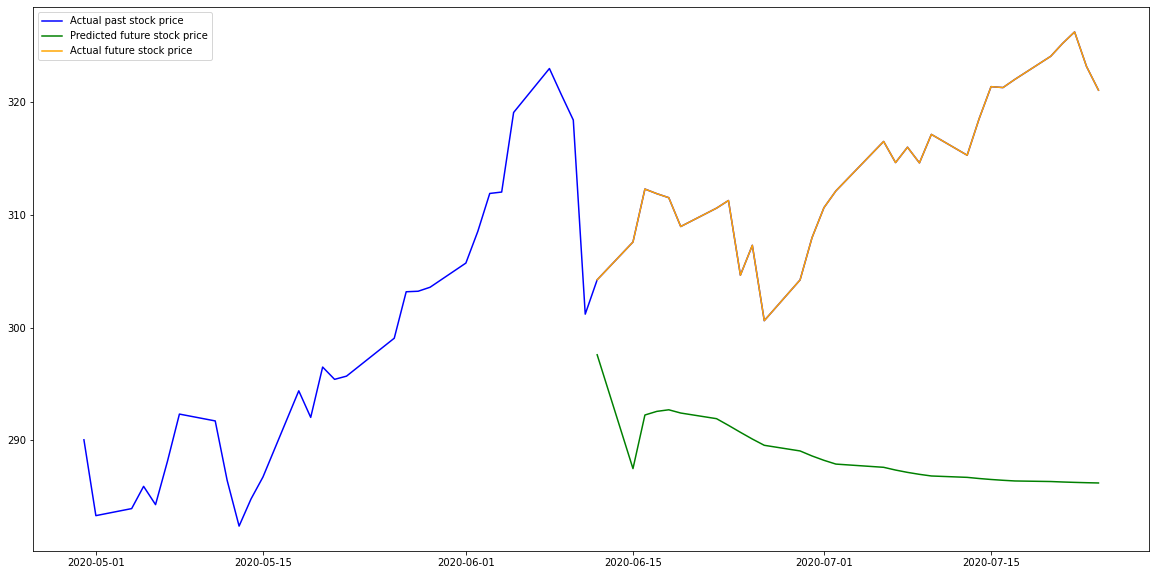

In [ ]:
#plt.plot(train['Close'][len(train)-len(valid):], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Close'][-(T_pred+T):], color = 'blue', label='Actual past stock price')
plt.plot(valid['Predictions'][-T_pred:], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'][-T_pred:], color = 'orange', label='Actual future stock price')
plt.legend()

In [ ]:
rms1=np.sqrt(np.mean(np.power((valid['Predictions'][-T_pred:] - valid['Close'][-T_pred:]),2)))
print('RMS error of final prediction: {:.2f}'.format(rms1))

RMS error of final prediction: 28.20


In [ ]:
#Attention model

hidden_size = 100
batch_size = 32

# Define an input sequence and process it.

encoder_inputs = Input(shape=(T, k), name='encoder_inputs')
decoder_inputs = Input(shape=(T_pred, 1), name='decoder_inputs')


# Encoder GRU
encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
encoder_out, encoder_state = encoder_gru(encoder_inputs)

# Set up the decoder GRU, using `encoder_states` as initial state.
decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

# Attention layer
attn_layer = Attention(causal=True, name='attention_layer')
attn_out = attn_layer([encoder_out, decoder_out])

# Concat attention input and decoder GRU output
#decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

# Dense layer
dense = Dense(1)
dense_time = TimeDistributed(dense, name='time_distributed_layer')
decoder_pred = dense_time(attn_out)

# Full model
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model.compile(optimizer='adam', loss='categorical_crossentropy')


full_model.summary()
tf.keras.utils.plot_model(full_model, show_shapes=True)

# """ Inference model """
# batch_size = 1

# """ Encoder (Inference) model """
# encoder_inf_inputs = Input(batch_shape=(batch_size, Ts, k), name='encoder_inf_inputs')
# encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
# encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

# """ Decoder (Inference) model """
# decoder_inf_inputs = Input(batch_shape=(batch_size, 1, 1), name='decoder_word_inputs')
# encoder_inf_states = Input(batch_shape=(batch_size, T, hidden_size), name='encoder_inf_states')
# decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

# decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
# attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
# decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
# decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
# decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
#                       outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])


In [ ]:
inputs = new_data[len(new_data) - len(valid) - T:len(new_data) - len(valid)].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = np.reshape(inputs, (1,-1,1))
X_test.shape
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price.shape

In [ ]:
#Predictions on test set
closing_price = np.zeros((len(valid)))
X_test = []
for pred in range(len(closing_price)):
  #Single valued output
  if pred<T:
    X_test = new_data[len(train) - T + pred:len(train)].values
    X_test = X_test.reshape(-1,1)
    X_test = scaler.transform(X_test)
    if pred>0:
      X_test = np.concatenate((X_test, closing_price[:pred]), axis = None)  
  if pred>=T:
    X_test = closing_price[pred - T:pred]
  X_test = np.array(X_test)
  X_test = X_test.reshape(-1,1)
  #X_test  = scaler.transform(X_test)

  X_test = np.reshape(X_test, (X_test.shape[1],X_test.shape[0],1))
  closing_price[pred] = model.predict(X_test)
  #closing_price[pred] = scaler.inverse_transform(closing_price[pred]) 

closing_price = closing_price.reshape(-1,1)
closing_price = scaler.inverse_transform(closing_price)
closing_price.shape #single valued output prediction

In [ ]:
print(closing_price.shape)
print(X_test.shape)
print(x_train.shape)
print(y_train.shape)

(292, 1)
(1, 90, 1)
(710, 90, 1)
(710,)


In [ ]:
closing_price


In [ ]:
#rms error
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
#np.mean(np.abs(valid - closing_price))

Close          163.078557
Predictions    158.291392
dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


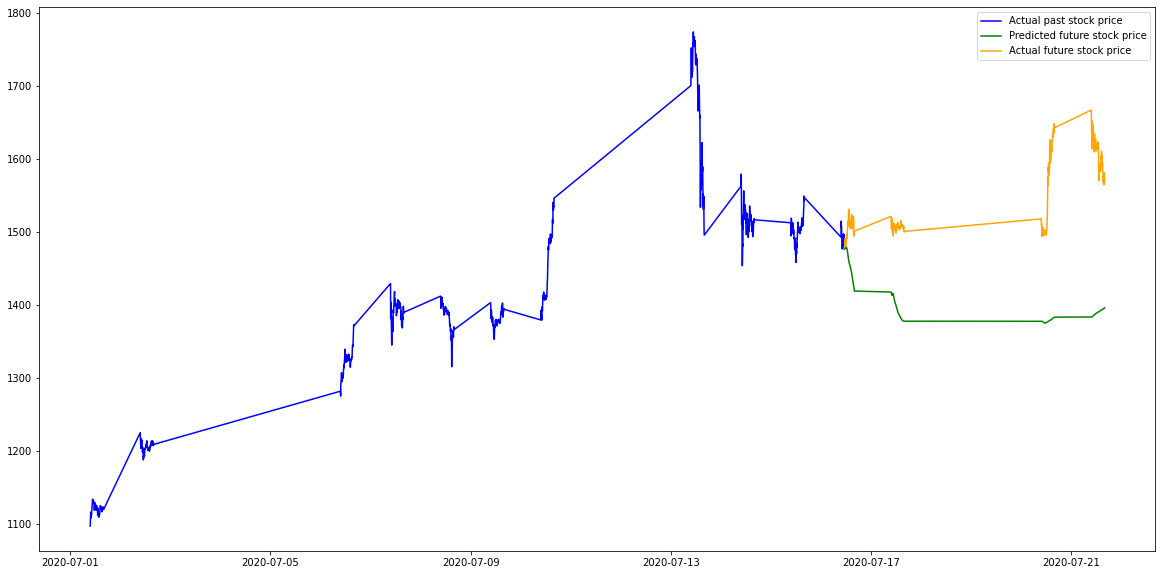

In [ ]:
#for plotting
train = new_data[:800]
#train_pred = new_data[T:450]
valid = new_data[800:]
#train_pred['Predictions'] = closing_price_train
valid['Predictions'] = closing_price
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()



In [ ]:
valid

,Close,Predictions
Date,,
2019-11-01,1273.74,1244.864561
2019-11-04,1291.37,1235.571965
2019-11-05,1292.03,1225.102388
2019-11-06,1291.8,1212.246379
2019-11-07,1308.86,1201.619072
...,...,...
2020-07-14,1520.58,1195.485181
2020-07-15,1513.64,1195.874253
2020-07-16,1518,1196.312305


In [ ]:
valid.to_csv('/content/drive/My Drive/Covid 19 part(2)/Results_1/TESLA_Predicted_vs_Actual_Stock_Prices_JULY.csv')

In [ ]:
#Prediction for 22nd July, 2017
inputs = new_data[len(new_data) - T:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = inputs
X_test = X_test.reshape(1,T,1)

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
print('Price on 22nd July : {}'.format(closing_price[0][0]))

Price on 22nd July : 1605.862060546875


In [ ]:
#learning rate decay(picking optimum learning rate)
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

In [ ]:
#plotting loss per epoch against learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
#use this to choose the optimum lr and run the NN for 500 epochs

In [ ]:
#Conv1D
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape = [None,1])

In [ ]:
#Converting the data in a df to float
df = df.astype('float64')

In [ ]:
#concatenating two colums
data['date_time'] = data['date'].str.cat(data['time'], sep=' ')

In [ ]:
#getting daily data from minute/hour wise data
df = df.resample('D').mean() # if we want mean of time data
df = df.resample('D').sum() # if we want sum of time data

In [ ]:
#evaluate model for multi-step LSTM
def evaluate_model(y_true, y_predicted):
  scores = []

  #calculating score for each day
  for i in range(y_true.shape[1]):
    mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
    rmse = np.sqrt(mse)
    scores.append(rmse)

  #calculating score for whole prediction
  total_score = 0
  for row in range(y_true.shape[0]):
    for col in range(y_predicted.shape[1]):
      total_score = total_score + (y_true[row,col] - y_predicted[row,col])**2
  total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))

  return total_ score, scores

evaluate_model(y_true, y_pred)
np.std(y_true[0])



In [ ]:
data = pd.read_csv('/content/drive/My Drive/Covid 19 part(2)/LSTM/AAPL_JAN18_JULY20.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
data_training = data[data['Date'] < '2019-12-31'].copy()
data_training

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
485,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.562683,24643000
486,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.831299,12119700
487,2019-12-26,284.820007,289.980011,284.700012,289.910004,288.442780,23280300
488,2019-12-27,291.119995,293.970001,288.119995,289.799988,288.333313,36566500


In [ ]:
data_testing = data[data['Date'] >= '2019-12-31'].copy()
data_testing

,Date,Open,High,Low,Close,Adj Close,Volume
490,2019-12-31,289.929993,293.679993,289.519989,293.649994,292.163818,25201400
491,2020-01-02,296.239990,300.600006,295.190002,300.350006,298.829956,33870100
492,2020-01-03,297.149994,300.579987,296.500000,297.429993,295.924713,36580700
493,2020-01-06,293.790009,299.959991,292.750000,299.799988,298.282715,29596800
494,2020-01-07,299.839996,300.899994,297.480011,298.390015,296.879883,27218000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
training_data = data_training.drop(['Date', 'Adj Close'], axis=1)
training_data

,Open,High,Low,Close,Volume
0,178.610001,179.580002,177.410004,178.460007,32425100
1,177.300003,177.779999,176.600006,177.000000,27108600
2,177.300003,179.440002,176.820007,177.039993,32689100
3,177.250000,177.300003,173.199997,174.220001,51105100
4,174.509995,174.949997,170.529999,171.110001,41529000
...,...,...,...,...,...
485,280.529999,284.250000,280.369995,284.000000,24643000
486,284.690002,284.890015,282.920013,284.269989,12119700
487,284.820007,289.980011,284.700012,289.910004,23280300
488,291.119995,293.970001,288.119995,289.799988,36566500


In [ ]:
scalar = MinMaxScaler()
training_data = scalar.fit_transform(training_data)
training_data.shape

(490, 5)

In [ ]:
x_train = []
y_train = []

T = 60
for i in range(T, training_data.shape[0]):
  x_train.append(training_data[i-T:i])
  y_train.append(training_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(430, 60, 5)
(430,)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,901
Trainable params: 91,901
Non-trainable params: 0
__________________________________________________

In [ ]:
import time
start = time.time()
model.fit(x_train, y_train, epochs=50, batch_size=8)
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0159
Epoch 2/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0041
Epoch 3/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0029
Epoch 4/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0030
Epoch 5/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 6/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0024
Epoch 8/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0024
Epoch 9/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0038
Epoch 10/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0022
Epoch 11/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0019
Epoch 12/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0020
Epoch 13/50
54/54 [==================

In [ ]:
past_T_days = data_training.tail(T)

df = past_T_days.append(data_testing, ignore_index = True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-04,225.639999,227.490005,223.889999,227.009995,225.185043,34619700
1,2019-10-07,226.270004,229.929993,225.839996,227.059998,225.234634,30576500
2,2019-10-08,225.820007,228.059998,224.330002,224.399994,222.596024,27955000
3,2019-10-09,227.029999,227.789993,225.639999,227.029999,225.204895,18692600
4,2019-10-10,227.929993,230.440002,227.300003,230.089996,228.240280,28253400
...,...,...,...,...,...,...,...
192,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
193,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
194,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
195,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
df = df.drop(['Date', 'Adj Close'], axis=1)
df

,Open,High,Low,Close,Volume
0,225.639999,227.490005,223.889999,227.009995,34619700
1,226.270004,229.929993,225.839996,227.059998,30576500
2,225.820007,228.059998,224.330002,224.399994,27955000
3,227.029999,227.789993,225.639999,227.029999,18692600
4,227.929993,230.440002,227.300003,230.089996,28253400
...,...,...,...,...,...
192,381.339996,383.920013,378.820007,383.679993,22564300
193,389.059998,399.820007,381.029999,381.910004,47912300
194,379.359985,389.019989,375.510010,388.230011,42747300
195,395.959991,396.989990,385.959991,390.899994,38299500


In [ ]:
inputs = scalar.transform(df)
inputs.shape

(197, 5)

In [ ]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]
 
# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
  X1, X2, y = list(), list(), list()
  for _ in range(n_samples):
    # generate source sequence
    source = generate_sequence(n_in, cardinality)
    # define padded target sequence
    target = source[:n_out]
    target.reverse()
    # create padded input target sequence
    target_in = [0] + target[:-1]
    # encode
    src_encoded = to_categorical([source], num_classes=cardinality)
    tar_encoded = to_categorical([target], num_classes=cardinality)
    tar2_encoded = to_categorical([target_in], num_classes=cardinality)
    # store
    X1.append(src_encoded)
    X2.append(tar2_encoded)
    y.append(tar_encoded)
  return array(X1), array(X2), array(y)
 
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

In [ ]:
# configure problem
n_features = 50 + 1
n_steps_in = 6
n_steps_out = 3

# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print(X1.shape,X2.shape,y.shape)

(100000, 1, 6, 51) (100000, 1, 3, 51) (100000, 1, 3, 51)
